In [2]:
%matplotlib notebook

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pylab
import statistics as st
from sklearn import linear_model, metrics
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pyAgrum as gum
import pandas as pd
import pydotplus
import pyAgrum.lib.notebook as gnb
import numpy as np

In [157]:
dfa = pd.read_csv('Adult/adult_cleaned_bin.csv')#adult
dfa['Sex']=dfa['Sex'].replace({0:1,1:0})
dfa['race']=dfa['race'].replace({0:1,1:0})
dfa['age']=dfa['age'].replace({0:1,1:0})
dfa.head()

,age,workclass,education,marital_status,occupation,relationship,race,hours_per_week,native_country,income,Sex
0,0,1,1,1,1,1,0,0,1,0,1
1,0,1,0,1,0,1,0,1,1,0,1
2,0,1,1,1,1,0,0,1,1,0,1
3,0,1,0,1,1,1,0,1,1,0,0
4,0,1,1,1,1,0,0,0,1,1,1


In [158]:
dfd = pd.read_csv('Dutch/dutch_simplified2.csv') #dutch
dfd['economic_status'] = [1 if x<120 else 0 for x in dfd.economic_status]
dfd['Marital_status'] = [0 if x<3 else 1 for x in dfd.Marital_status]
dfd['age'] = [1 if x<9 else 0 for x in dfd.age]
dfd.head()

,sex,occupation,age,edu_level,Marital_status,economic_status
0,0,0,1,5,0,1
1,1,1,0,2,0,1
2,0,0,1,2,0,1
3,0,1,0,1,0,1
4,1,1,1,2,0,1


In [165]:
dfc = pd.read_csv('Compas/compas_cleaned_binarized.csv')#compas
dfc['race']=dfc['race'].replace({0:1,1:0})
dfc['sex']=dfc['sex'].replace({0:1,1:0})

In [167]:
dfcc = pd.read_csv('Communities/communities_simplified_binarized.csv')#communities and cirme
dfcc['race']=dfcc['race'].replace({0:1,1:0})

In [162]:
dfb = pd.read_csv('Boston/boston_data_simplified.csv') #Boston housing

In [172]:
#binarize 1 is more than mean, else 0
dfb.describe()
dfb['crime']= [1 if x >3.613524 else 0 for x in dfb.CRIM]
dfb['race']= [1 if x >356.674032 else 0 for x in dfb.B]
dfb['value'] = [1 if x >22.532806 else 0 for x in dfb.MEDV]

In [173]:
dfc_2 = pd.read_csv('Compas/compas_not_bin.csv')#adult
dfc_2.head()

,sex,race,age,two_year_recid,priors_count
0,1,0,34,1,0
1,1,0,24,1,4
2,1,1,41,1,14
3,0,1,39,0,0
4,1,1,21,1,1


## Confounder Bias

\begin{equation}
ConfBias(Y,A,Z) = StatDisp(Y,A) - ACE(Y,A)
\end{equation} 
 
 $\displaystyle ACE(Y,A)_Z = \sum_{z\in Z}\left(P(y_1|a_1, Z=z)-P(y_1|a_0, Z=z)\right).P(Z=z)$, and
 $StatDisp(Y,A) = P(y_1 | a_1) - P(y_1 | a_0)$


\begin{align}
ConfBias(Y,A) &= (1- P(z_1|a_0) - P(z_1))(\alpha -\beta +\gamma -\delta)
\end{align} 

\begin{align}
% % \tau &= P(a_0|z_0) \nonumber \\
% % \epsilon &= P(z_0) \nonumber \\
 \alpha &= P(y_1|a_0,z_0) \nonumber \\
 \beta &= P(y_1|a_0,z_1) \nonumber \\
 \gamma &= P(y_1|a_1,z_0) \nonumber \\
 \delta &= P(y_1|a_1,z_1) \nonumber 
 \end{align}   


In [201]:
def causaleffect(df,y, a, z): #using expression
    
    py1a0z0 = df[(df[y]==1)&(df[z]==0)&(df[a]==0)].shape[0]/df[(df[z]==0)&(df[a]==0)].shape[0]
    py1a0z1 = df[(df[y]==1)&(df[z]==1)&(df[a]==0)].shape[0]/df[(df[z]==1)&(df[a]==0)].shape[0]
    py1a1z0 = df[(df[y]==1)&(df[z]==0)&(df[a]==1)].shape[0]/df[(df[z]==0)&(df[a]==1)].shape[0]
    py1a1z1 = df[(df[y]==1)&(df[z]==1)&(df[a]==1)].shape[0]/df[(df[z]==1)&(df[a]==1)].shape[0]
    pz1 = df[(df[z]==1)].shape[0]/df.shape[0]
    pz0 = df[(df[z]==0)].shape[0]/df.shape[0]
    ydoa1 = (py1a1z1*pz1)+(py1a1z0*pz0)
    ydoa0 = (py1a0z1*pz1)+(py1a0z0*pz0)
    CE=ydoa1-ydoa0
    return CE

 
    
def SD(df,y, a):
       py1a0 = df[(df[y]==1)&(df[a]==0)].shape[0]/df[(df[a]==0)].shape[0]
       py1a1 = df[(df[y]==1)&(df[a]==1)].shape[0]/df[(df[a]==1)].shape[0]
       SD = py1a1 - py1a0
       return SD
       




def confbias(df,y, a, z):
#     pz1a0 = df[(df[z]==1)&(df[a]==0)].shape[0]/df[df[a]==0].shape[0]
#     pz1 = df[(df[z]==1)].shape[0]/df.shape[0]
#     py1a0z0 = df[(df[y]==1)&(df[z]==0)&(df[a]==0)].shape[0]/df[(df[z]==0)&(df[a]==0)].shape[0]
#     py1a0z1 = df[(df[y]==1)&(df[z]==1)&(df[a]==0)].shape[0]/df[(df[z]==1)&(df[a]==0)].shape[0]
#     py1a1z0 = df[(df[y]==1)&(df[z]==0)&(df[a]==1)].shape[0]/df[(df[z]==0)&(df[a]==1)].shape[0]
#     py1a1z1 = df[(df[y]==1)&(df[z]==1)&(df[a]==1)].shape[0]/df[(df[z]==1)&(df[a]==1)].shape[0]
 
#     bias = (1-pz1a0-pz1)*(py1a0z0-py1a0z1+py1a1z0-py1a1z1) #using expression
    CE= causaleffect(df,y, a, z) 
    sd = SD(df,y, a)
    bias=sd-CE

    return bias


    
    

In [169]:
biasa = confbias(dfa,'income', 'marital_status', 'age')
print(biasa)
sda = SD(dfa,'income', 'marital_status')
print(sda)

-0.03545924237380804
-0.3840644795305541


In [174]:
#Adult

biasa = confbias(dfa,'income', 'marital_status', 'age')
print(biasa)
sda = SD(dfa,'income', 'marital_status')
print(sda)

biasa2 = confbias(dfa,'income', 'marital_status', 'Sex')
print(biasa2)
sda2 = SD(dfa,'income', 'marital_status')
print(sda2)

biasa3 = confbias(dfa,'income', 'marital_status', 'race')
print(biasa3)
sda3 = SD(dfa,'income', 'marital_status')
print(sda3)

biasa4 = confbias(dfa,'income', 'marital_status', 'native_country')
print(biasa3)
sda4 = SD(dfa,'income', 'marital_status')
print(sda4)

#Dutch
biasd = confbias(dfd,'economic_status', 'Marital_status', 'age')
print(biasd)
sdd = SD(dfd,'economic_status', 'Marital_status')
print(sdd)

biasd2 = confbias(dfd,'economic_status', 'Marital_status', 'sex')
print(biasd2)
sdd2 = SD(dfd,'economic_status', 'Marital_status')
print(sdd2)


-0.03545924237380804
-0.3840644795305541
-0.006422753004922621
-0.3840644795305541
-0.003559882772657841
-0.3840644795305541
-0.003559882772657841
-0.3840644795305541
-0.015810009320393115
0.00012083486271330379
0.010671631185156016
0.00012083486271330379


In [175]:
#Compas

biasc = confbias(dfc,'two_year_recid', 'race', 'age')
print(biasc)
sdc= SD(dfc,'two_year_recid', 'race')
print(sdc)

biasc2 = confbias(dfc,'two_year_recid', 'race', 'sex')
print(biasc2)
sdc2= SD(dfc,'two_year_recid', 'race')
print(sdc2)

#Boston
biasb = confbias(dfb,'value', 'race', 'crime')
print(biasb)
sdb= SD(dfb,'value', 'race')
print(sdb)



0.021887690260378345
0.12597488570305548
0.0052735951941318415
0.12597488570305548
0.07590523534461618
0.34541062801932365


<IPython.core.display.Javascript object>


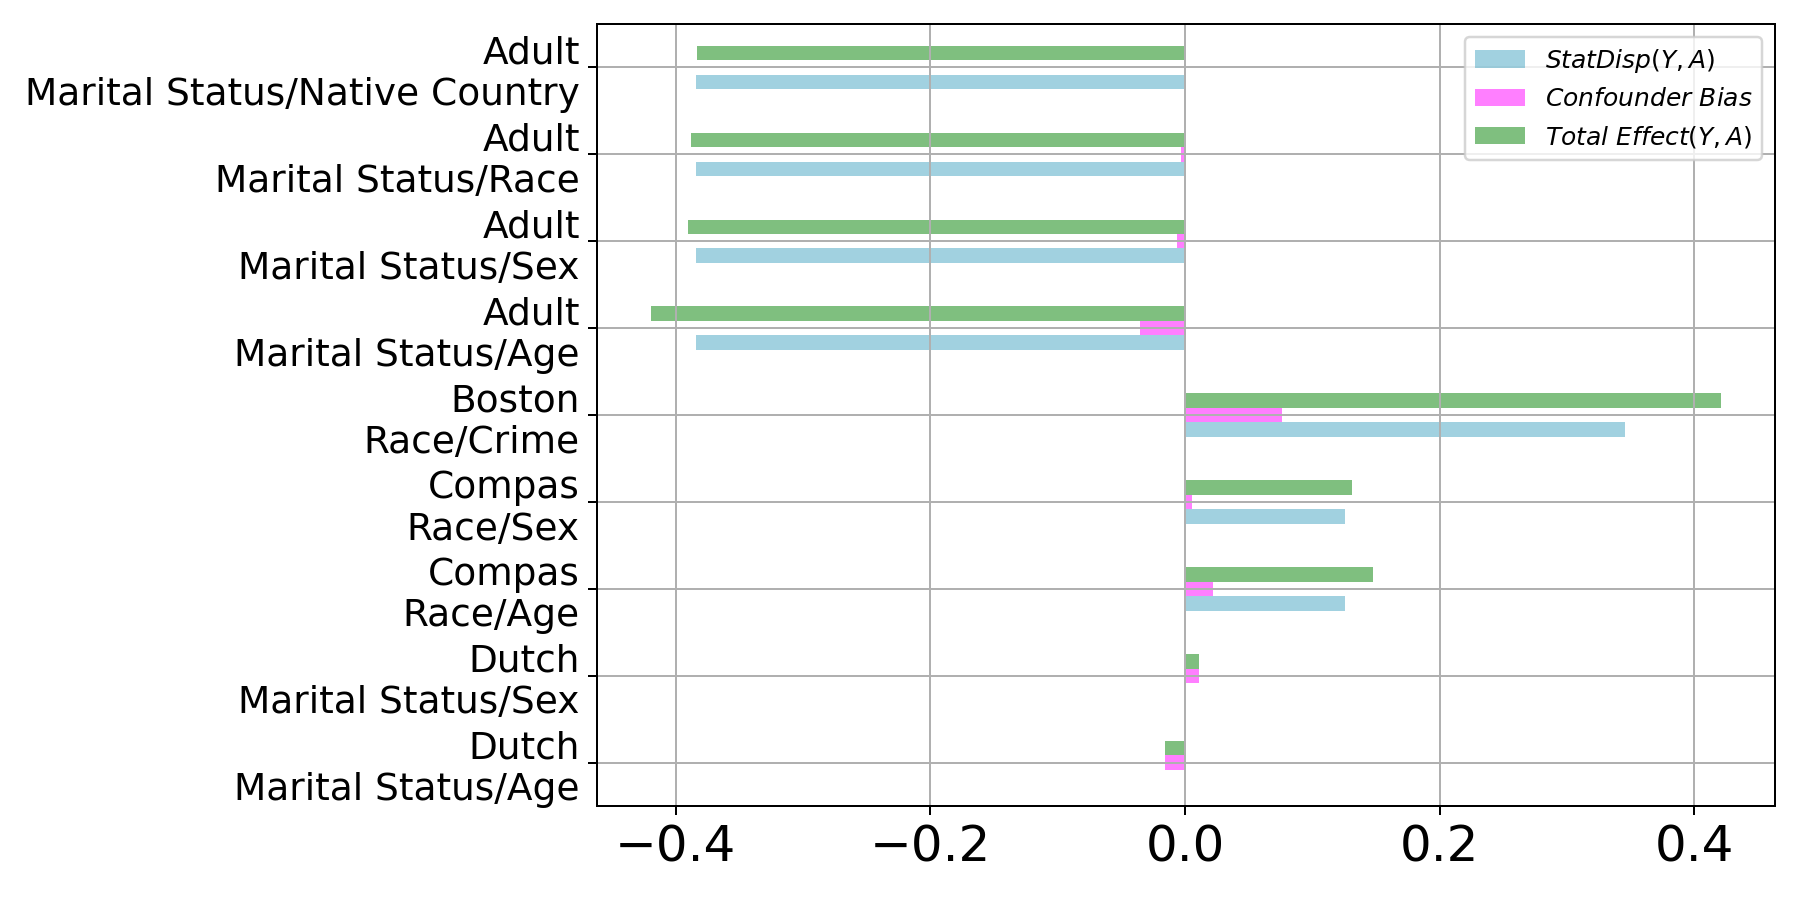

In [176]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')
Sd=(sdd,sdd2,sdc,sdc2,sdb, sda,sda2,sda3,sda4)
bias=(biasd,biasd2,biasc,biasc2,biasb, biasa,biasa2,biasa3,biasa4)
total = (sdd+biasd, sdd2+biasd2,biasc+sdc,biasc2+sdc2,sdb+biasb, sda+biasa, sda2+biasa2, sda3+biasa3, sda4+biasa4)

names = ('Dutch\nMarital Status/Age','Dutch\nMarital Status/Sex','Compas\nRace/Age','Compas\nRace/Sex','Boston\nRace/Crime','Adult\nMarital Status/Age','Adult\nMarital Status/Sex', 'Adult\nMarital Status/Race', 'Adult\nMarital Status/Native Country')

df = pd.DataFrame({'$StatDisp(Y,A$)': Sd,'$Confounder ~Bias$': bias,'$Total~Effect (Y,A)$': total}, index=names)
df.plot.barh(color=["#44a5c2",  "magenta",  'green'], alpha=0.5, ax=ax)
ax.set_facecolor('white')
plt.grid(False)
# plt.margins(x=0)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=15)
plt.grid(True)
plt.tight_layout(pad=1)

plt.savefig('confounderbias.png',bbox_inches='tight', dpi=300)

## Multiple Confounding Bias

$P(Y|do(a))=\sum_{z_1, z_2, z_3}{P(Y|z_1,z_2,z_3,x)P(z_1, z_2, z_3)}$ 

In [177]:
import itertools

def two_conf(df, a, y, Z):
    n = len(Z)+1
    lst = list(itertools.product([0, 1], repeat=n))
    components= []
    for l in lst:
        py = df[(df[y]==1)&(df[a]==l[0])&(df[Z[0]]==l[1])&(df[Z[1]]==l[2])].shape[0]/df[(df[a]==l[0])&(df[Z[0]]==l[1])&(df[Z[1]]==l[2])].shape[0]
#         print(py)
        pz = df[(df[Z[0]]==l[1])&(df[Z[1]]==l[2])].shape[0]/ df.shape[0]
#         print(pz)
        p = py*pz
        components.append(p)

    return sum(components)

def four_conf(df, a, y, Z):
    n = len(Z)+1
    lst = list(itertools.product([0, 1], repeat=n))
    components= []
    for l in lst:
        py = df[(df[y]==1)&(df[a]==l[0])&(df[Z[0]]==l[1])&(df[Z[1]]==l[2])&(df[Z[2]]==l[3])&(df[Z[3]]==l[4])].shape[0]/df[(df[a]==l[0])&(df[Z[0]]==l[1])&(df[Z[1]]==l[2])&(df[Z[2]]==l[3])&(df[Z[3]]==l[4])].shape[0]
#         print(py)
        pz = df[(df[Z[0]]==l[1])&(df[Z[1]]==l[2])&(df[Z[2]]==l[3])&(df[Z[3]]==l[4])].shape[0]/ df.shape[0]
#         print(pz)
        p = py*pz
        components.append(p)

    return sum(components)
        
    

In [178]:
df = dfd
a =  'Marital_status'
y = 'economic_status'
Z = ['age', 'sex']

TEa_d = two_conf(df, a, y, Z)
TEa_d
    

1.845663133963297

In [179]:
df = dfa
a =  'marital_status'
y = 'income'
Z = ['age', 'Sex', 'race','native_country']

TEa_a = four_conf(df, a, y, Z)
TEa_a

0.5578169812469068

In [180]:
df = dfc
a =  'race'
y = 'two_year_recid'
Z = ['age', 'sex']

TEa_c = two_conf(df, a, y, Z)
TEa_c

0.9326105621971628

<IPython.core.display.Javascript object>


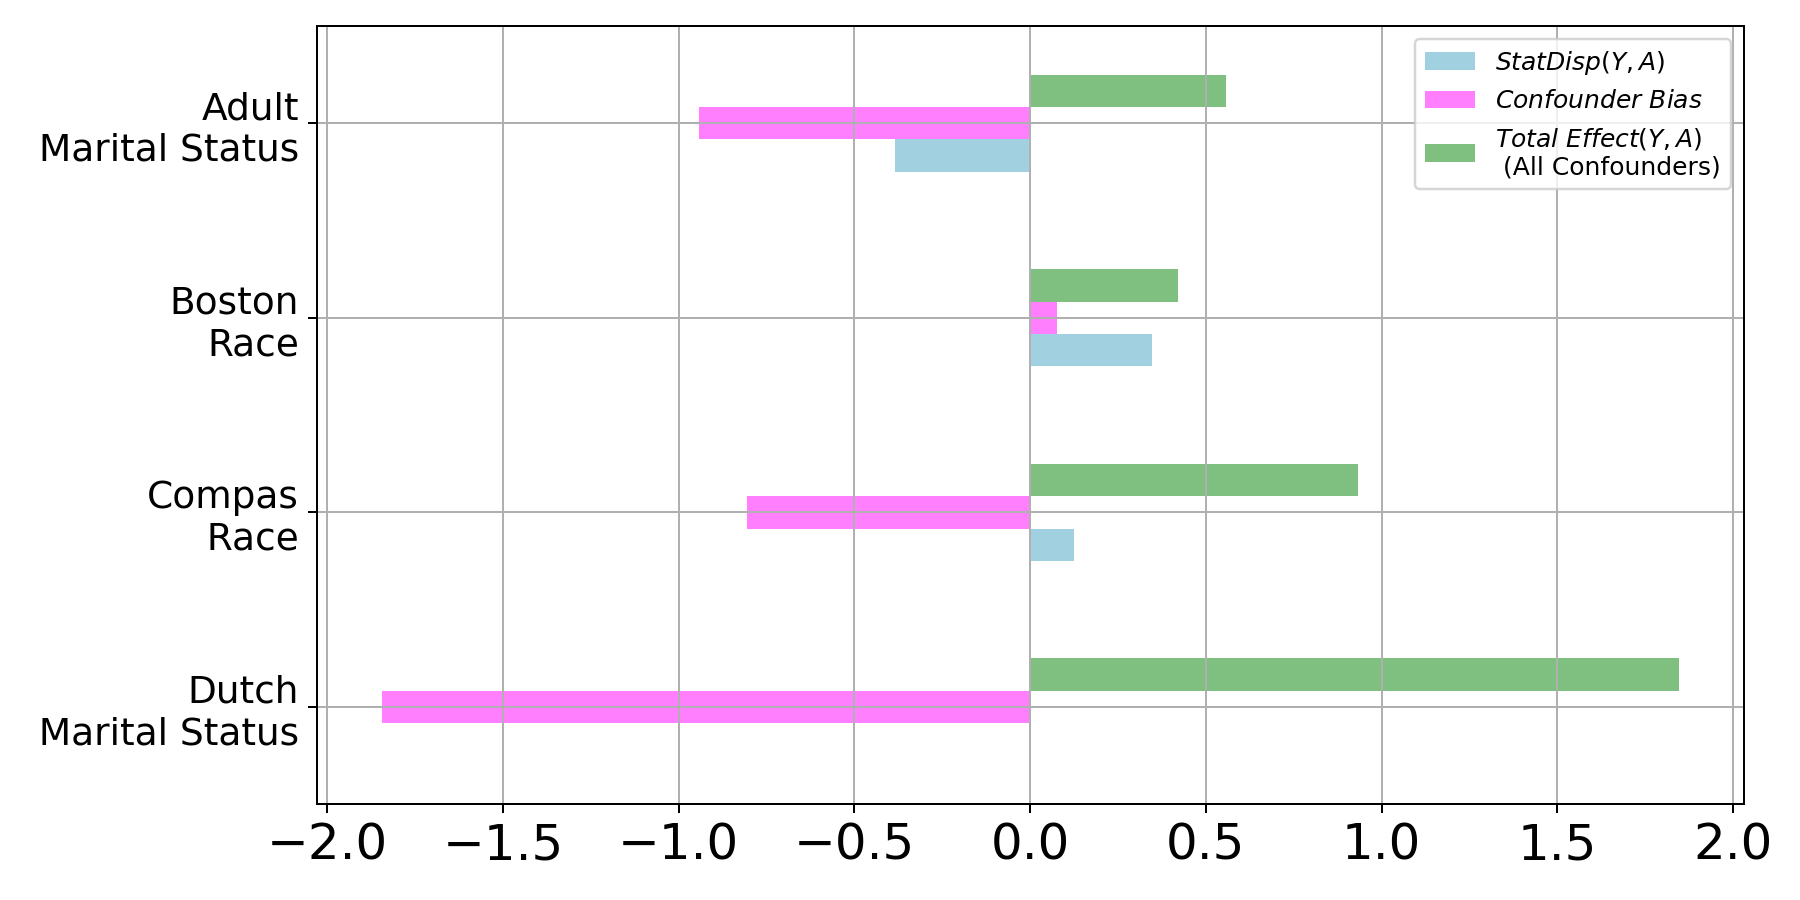

In [181]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

statdisp = (sdd,sdc,sdb,sda)
mults = (TEa_d, TEa_c, sdb+biasb, TEa_a)
bias = [sdd-TEa_d, sdc-TEa_c,biasb,sda-TEa_a  ]
names = ('Dutch\n Marital Status','Compas\n Race','Boston\nRace','Adult\nMarital Status' )

df = pd.DataFrame({'$StatDisp(Y,A)$': statdisp,'$Confounder~Bias$':bias,'$Total ~Effect (Y,A)$\n (All Confounders)': mults}, index=names)
df.plot.barh(color=["#44a5c2",  "magenta",  'green'], alpha=0.5, ax=ax)
plt.grid(False)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig('confounderbias_withMult.png',bbox_inches='tight', dpi=300)

## Collider Bias

\begin{equation}
SelBias(Y,A,W) = StatDisp(Y,A)_W - StatDisp(Y,A)
\end{equation}


 
 $\displaystyle StatDisp(Y,A)_W = \sum_{w\in W}\left(P(y_1|a_1, W=w)-P(y_1|a_0, W=w)\right).P(W=w)$, and
 $StatDisp(Y,A) = P(y_1 | a_1) - P(y_1 | a_0)$


$ SelBias(Y,A) = (1- P(w_0|a_0) - P(w_1))(-\alpha +\beta -\gamma + \delta)$

In [182]:
def colbias(df,y, a, w):
  
    pw0 = df[(df[w]==0)].shape[0]/df.shape[0]
    pw1 = df[(df[w]==1)].shape[0]/df.shape[0]
    py1a0w0 = df[(df[y]==1)&(df[w]==0)&(df[a]==0)].shape[0]/df[(df[w]==0)&(df[a]==0)].shape[0]
    py1a0w1 = df[(df[y]==1)&(df[w]==1)&(df[a]==0)].shape[0]/df[(df[w]==1)&(df[a]==0)].shape[0]
    py1a1w0 = df[(df[y]==1)&(df[w]==0)&(df[a]==1)].shape[0]/df[(df[w]==0)&(df[a]==1)].shape[0]
    py1a1w1 = df[(df[y]==1)&(df[w]==1)&(df[a]==1)].shape[0]/df[(df[w]==1)&(df[a]==1)].shape[0]
    
    sdw = (py1a0w0-py1a1w0)*pw0+(py1a0w1-py1a1w1)*pw1
    sd = SD(df,y, a)
 
    bias = sdw-sd
    return bias

    
def SD(df,y, a):
       py1a0 = df[(df[y]==1)&(df[a]==0)].shape[0]/df[(df[a]==0)].shape[0]
       py1a1 = df[(df[y]==1)&(df[a]==1)].shape[0]/df[(df[a]==1)].shape[0]
       SD = py1a1 - py1a0
       return SD

In [183]:
a = 'Sex'
y = 'occupation'
w='income'
cobias_a = colbias(dfa,y, a, w)
print(cobias_a)
sda = SD(dfa,y, a)
print(sda)

-0.6780856313910124
0.32181842386706466


In [184]:
a = 'sex'
y = 'occupation'
w='economic_status'
cobias_d = colbias(dfd,y, a, w)
print(cobias_d)
sdd = SD(dfd,y, a)
print(sdd)

-0.5797860117069419
0.2984780416148498


In [185]:
a = 'race'
y = 'ViolentCrimesPerPop'
w='TotalPctDiv'
cobias_cc1 = colbias(dfcc,y, a, w)
print(cobias_cc1)
sdcc = SD(dfcc,y, a)
print(sdcc)

-0.8537582445376368
0.46432533796413544


In [186]:
a = 'race'
y = 'ViolentCrimesPerPop'
w='PctUnemployed'
cobias_cc2 = colbias(dfcc,y, a, w)
print(cobias_cc2)
sdcc = SD(dfcc,y, a)
print(sdcc)

-0.8111205433727948
0.46432533796413544


In [187]:
a = 'race'
y = 'ViolentCrimesPerPop'
w='PctPopUnderPov'
cobias_cc3 = colbias(dfcc,y, a, w)
print(cobias_cc3)
sdcc = SD(dfcc,y, a)
print(sdcc)

-0.7891019589090489
0.46432533796413544


In [188]:
a = 'race'
y = 'ViolentCrimesPerPop'
w='agePct65up'
cobias_cc4 = colbias(dfcc,y, a, w)
print(cobias_cc4)
sdcc = SD(dfcc,y, a)
print(sdcc)

-0.935715264233315
0.46432533796413544


<IPython.core.display.Javascript object>


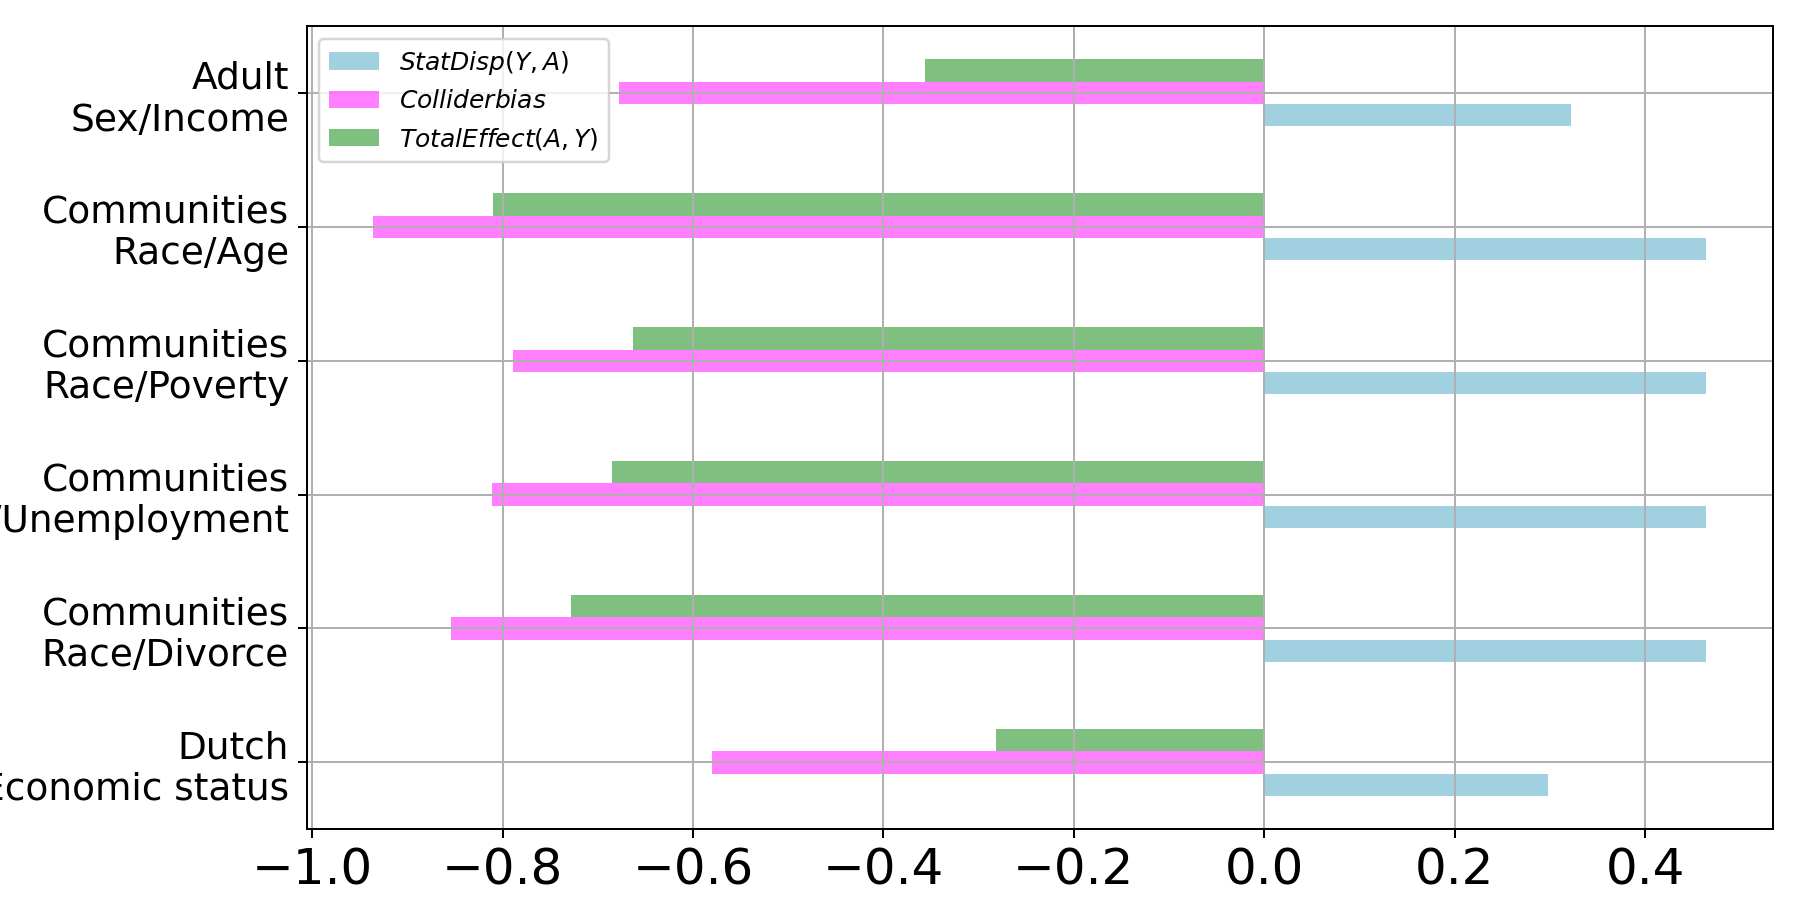

In [189]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

sD=(sdd,sdcc,sdcc,sdcc,sdcc,sda)
bias=(cobias_d,cobias_cc1,cobias_cc2,cobias_cc3,cobias_cc4,cobias_a)
total = (sdd+cobias_d, cobias_cc1+sdc, cobias_cc2+sdc,cobias_cc3+sdc,cobias_cc4+sdc,sda+cobias_a)

names = ('Dutch\nSex/Economic status','Communities\nRace/Divorce','Communities\nRace/Unemployment', 'Communities\nRace/Poverty','Communities\nRace/Age','Adult\nSex/Income')

df = pd.DataFrame({'$StatDisp(Y,A)$': sD,'$Collider bias$': bias,'$Total Effect(A,Y)$': total}, index=names)
df.plot.barh(color=["#44a5c2",  "magenta",  'green'], alpha=0.5, ax=ax)

plt.tight_layout()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=15)
plt.grid(True)
plt.savefig('colliderbias.png',bbox_inches='tight', dpi=300)


## Interaction Bias

\begin{align} \displaystyle
Effect(Y,A,B) &  = \big[P(Y_1|a_1, b_0)-P(Y_1|a_0, b_0)\big] \nonumber \\
 & \quad + \big[P(Y_1|a_0, b_1)-P(Y_1|a_0, b_0)\big]  \nonumber \\
& \quad + Interaction(A,B)  \nonumber 
\end{align}
where $Interaction(A,B) = P(Y_1|a_1, b_1) - P(Y_1|a_0, b_1) - P(Y_1|a_1, b_0) + P(Y_1|a_0, b_0)$

\begin{align} \displaystyle
 StatDisp(Y,A) & = \big[P(Y_1|a_1, b_0)-P(Y_1|a_0, b_0)\big]  \nonumber \\
& \quad + P(b_1)Interaction(A,B) \nonumber \\
& = \big[P(Y_1|a_1, b_1)-P(Y_1|a_0, b_1)\big] \nonumber \\
& \quad - P(b_0)Interaction(A,B) \nonumber
\end{align}

synergism is present if: 
$P(Y_1|a_1, b_1) - P(Y_1|a_0, b_1) - P(Y_1|a_1, b_0) > 0$

In [252]:
dfa.head()

,age,workclass,education,marital_status,occupation,relationship,race,hours_per_week,native_country,income,Sex
0,1,1,1,1,1,1,1,0,1,0,0
1,1,1,0,1,0,1,1,1,1,0,0
2,1,1,1,1,1,0,1,1,1,0,0
3,1,1,0,1,1,1,1,1,1,0,1
4,1,1,1,1,1,0,1,0,1,1,0


In [281]:
dfd.head()

,sex,occupation,age,edu_level,Marital_status,economic_status
0,0,0,0,5,1,0
1,1,1,1,2,1,0
2,0,0,0,2,1,0
3,0,1,1,1,1,0
4,1,1,0,2,1,0


In [190]:
def interaction(df,a, b, y):
    
    py1a0b0 = df[(df[y]==1)&(df[b]==0)&(df[a]==0)].shape[0]/df[(df[b]==0)&(df[a]==0)].shape[0]
    py1a0b1 = df[(df[y]==1)&(df[b]==1)&(df[a]==0)].shape[0]/df[(df[b]==1)&(df[a]==0)].shape[0]
    py1a1b0 = df[(df[y]==1)&(df[b]==0)&(df[a]==1)].shape[0]/df[(df[b]==0)&(df[a]==1)].shape[0]
    py1a1b1 = df[(df[y]==1)&(df[b]==1)&(df[a]==1)].shape[0]/df[(df[b]==1)&(df[a]==1)].shape[0]
    
    Int = py1a1b1- py1a0b1-py1a1b0+py1a0b0
    TEA =  py1a1b0- py1a0b0
    TEB = py1a0b1 - py1a0b0
#     SD = py1a1b1-py1a0b0
    total =  TEA+TEB+Int
    synergism = py1a1b1- py1a0b1- py1a1b0
    
    #statistical disparity thing
    py1a0 = df[(df[y]==1)&(df[a]==0)].shape[0]/df[(df[a]==0)].shape[0]
    py1a1 = df[(df[y]==1)&(df[a]==1)].shape[0]/df[(df[a]==1)].shape[0]
    
    SDA = py1a1-py1a0
    
    py1b0 = df[(df[y]==1)&(df[b]==0)].shape[0]/df[(df[b]==0)].shape[0]
    py1b1 = df[(df[y]==1)&(df[b]==1)].shape[0]/df[(df[b]==1)].shape[0]
    
    SDB = py1b1-py1b0
    
    SumSD = SDA+SDB
   
    
    return TEA, TEB, Int,total, synergism, SumSD
    

In [191]:
y = 'income'
a= 'race'
b= 'age'

metrics_a1 = interaction(dfa,a, b, y)

y = 'income'
a= 'Sex'
b= 'age'

metrics_a2 = interaction(dfa,a, b, y)

y = 'income'
a= 'Sex'
b= 'race'

metrics_a3 = interaction(dfa,a, b, y)

y = 'occupation'
a= 'sex'
b= 'age'
metrics_d1 = interaction(dfd,a, b, y)

In [192]:
metrics_d1[5]

0.4751996514844018

<IPython.core.display.Javascript object>


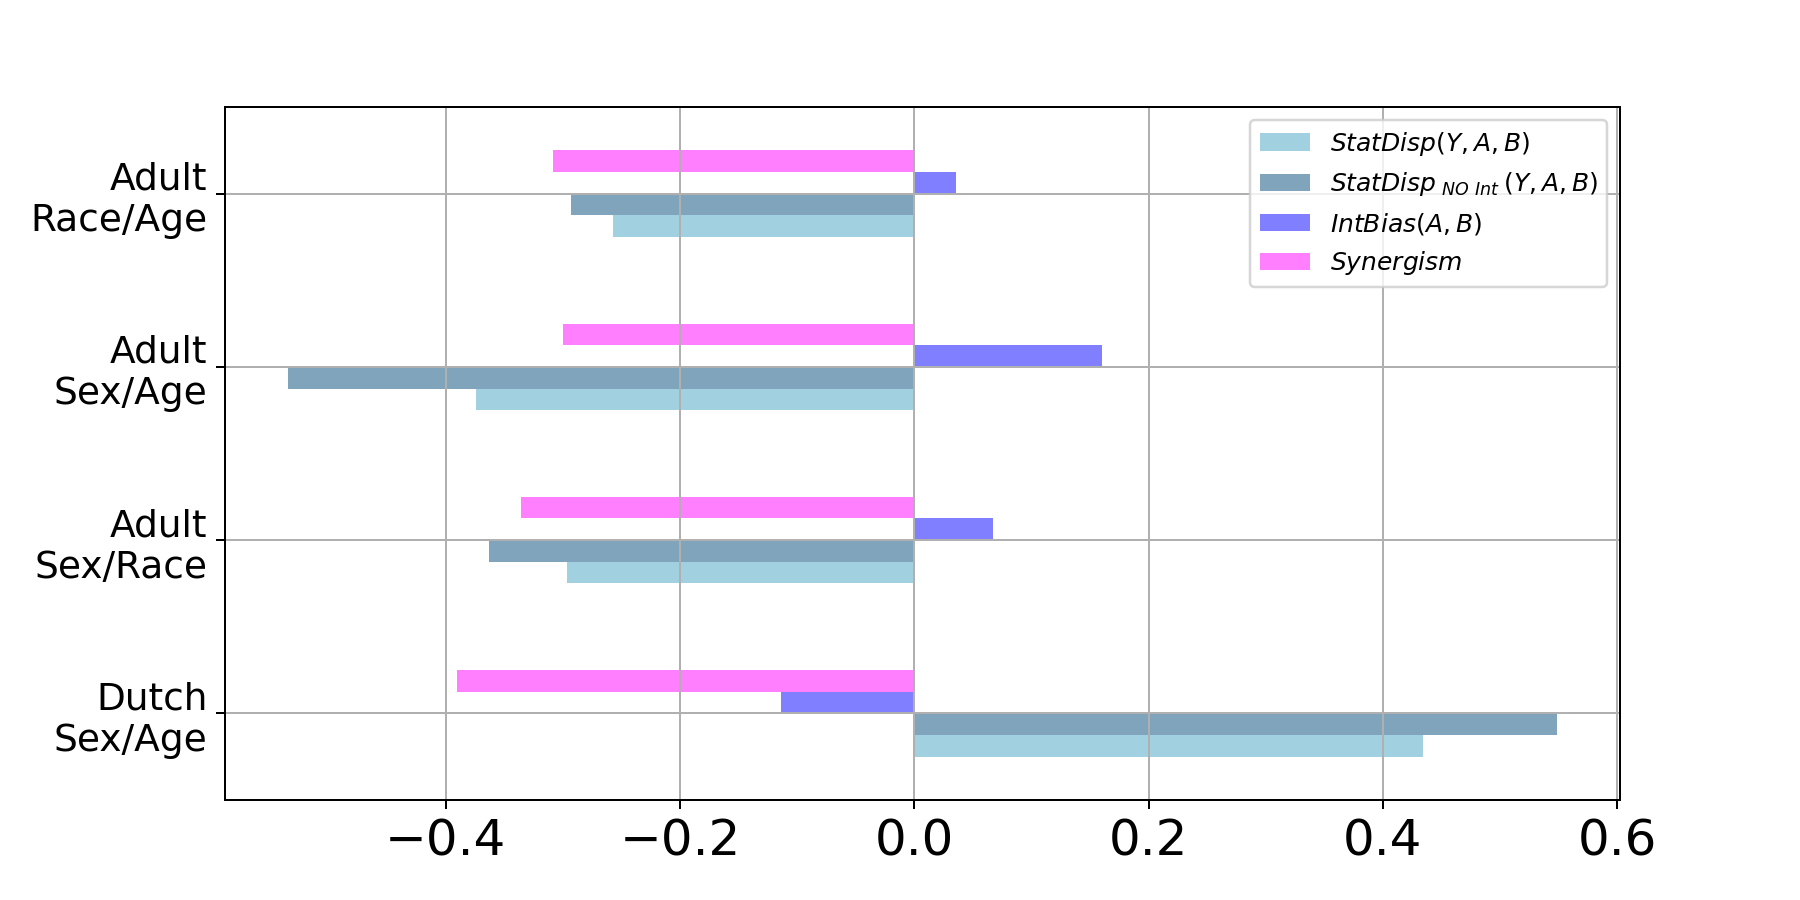

In [265]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

effects_A=(metrics_d1[0],metrics_a1[0],metrics_a2[0],metrics_a3[0])
effects_B=(metrics_d1[1],metrics_a1[1],metrics_a2[1],metrics_a3[1])

SDnointAB = (metrics_d1[0]+metrics_d1[1],metrics_a1[0]+metrics_a1[1],metrics_a2[0]+metrics_a2[1],metrics_a3[0]+metrics_a3[1])
interactions=(metrics_d1[2],metrics_a1[2],metrics_a2[2],metrics_a3[2])
total = (metrics_d1[3],metrics_a1[3],metrics_a2[3],metrics_a3[3])
synergism = (metrics_d1[4],metrics_a1[4],metrics_a2[4],metrics_a3[4])
sumSD = (metrics_d1[5],metrics_a1[5],metrics_a2[5],metrics_a3[5])
InterBias = (metrics_d1[5]-metrics_d1[3],metrics_a1[5]-metrics_a1[3],metrics_a2[5]-metrics_a2[3],metrics_a3[5]-metrics_a3[3])
names = ('Dutch\nSex/Age','Adult\nSex/Race', 'Adult\nSex/Age', 'Adult\nRace/Age')

df = pd.DataFrame({'$StatDisp(Y,A,B)$': total,
                   '$StatDisp_{~NO~Int~}(Y,A,B)$': SDnointAB, '$IntBias(A,B)$':interactions, '$Synergism$': synergism,}, index=names)
df.plot.barh(color=["#44a5c2",  "#024b7a", 'blue',  'magenta', 'y', 'r'], alpha=0.5, ax=ax)
plt.grid(False)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=15)
# ax.set_title('(a) Confounding Bias')
plt.grid(True)
plt.savefig('interactionAandB.png',bbox_inches='tight', dpi=300)

In [281]:
def single_effect(df,a, b, y):
    pb0 = df[(df[b]==0)].shape[0]/df.shape[0]
    pb1 = df[(df[b]==1)].shape[0]/df.shape[0]
    py1a0b0 = df[(df[y]==1)&(df[b]==0)&(df[a]==0)].shape[0]/df[(df[b]==0)&(df[a]==0)].shape[0]
    py1a0b1 = df[(df[y]==1)&(df[b]==1)&(df[a]==0)].shape[0]/df[(df[b]==1)&(df[a]==0)].shape[0]
    py1a1b0 = df[(df[y]==1)&(df[b]==0)&(df[a]==1)].shape[0]/df[(df[b]==0)&(df[a]==1)].shape[0]
    py1a1b1 = df[(df[y]==1)&(df[b]==1)&(df[a]==1)].shape[0]/df[(df[b]==1)&(df[a]==1)].shape[0]
    
    py1a0 = df[(df[y]==1)&(df[a]==0)].shape[0]/df[(df[a]==0)].shape[0]
    py1a1 = df[(df[y]==1)&(df[a]==1)].shape[0]/df[(df[a]==1)].shape[0]
    
    Int = py1a1b1- py1a0b1-py1a1b0+py1a0b0
    Intbias = pb1*Int
    TEA =  py1a1b0- py1a0b0
    Total = 0#TEA +  pb1*Int
    SD = py1a1-py1a0
    
    return  TEA, Intbias, Total, SD

In [282]:
y = 'income'
a= 'Sex'
b= 'age'

single_a2 = single_effect(dfa,a, b, y)
single_a2

single_b2 = single_effect(dfa,b, a, y)
single_b2

(-0.26381913248398264, 0.047431908638169644, 0, -0.22743472336189424)

In [283]:
y = 'income'
a= 'Sex'
b= 'race'

single_a3 = single_effect(dfa,a, b, y)
single_a3

single_b3 = single_effect(dfa,b, a, y)
single_b3

(-0.09156992007467474, 0.010610892554602236, 0, -0.10394758257296022)

In [284]:
y = 'income'
a= 'race'
b= 'age'

single_a1 = single_effect(dfa,a, b, y)
single_b1 = single_effect(dfa,b, a, y)

y = 'income'
a= 'Sex'
b= 'age'

single_a2 = single_effect(dfa,a, b, y)
single_b2 = single_effect(dfa,b, a, y)
y = 'income'
a= 'Sex'
b= 'race'

single_a3 = single_effect(dfa,a, b, y)
single_b3 = single_effect(dfa,b, a, y)
y = 'occupation'
a= 'sex'
b= 'age'
single_d1 = single_effect(dfd,a, b, y)
single_db1 = single_effect(dfd,b, a, y)

In [291]:
single_a3

(-0.20125812516731667, 0.004754985820468523, 0, -0.20145592925439365)

In [292]:
single_b3

(-0.09156992007467474, 0.010610892554602236, 0, -0.10394758257296022)

In [285]:
(single_d1[3],single_a1[3],single_a2[3],single_a3[3])

(0.2984780416148498,
 -0.10394758257296022,
 -0.20145592925439365,
 -0.20145592925439365)

<IPython.core.display.Javascript object>


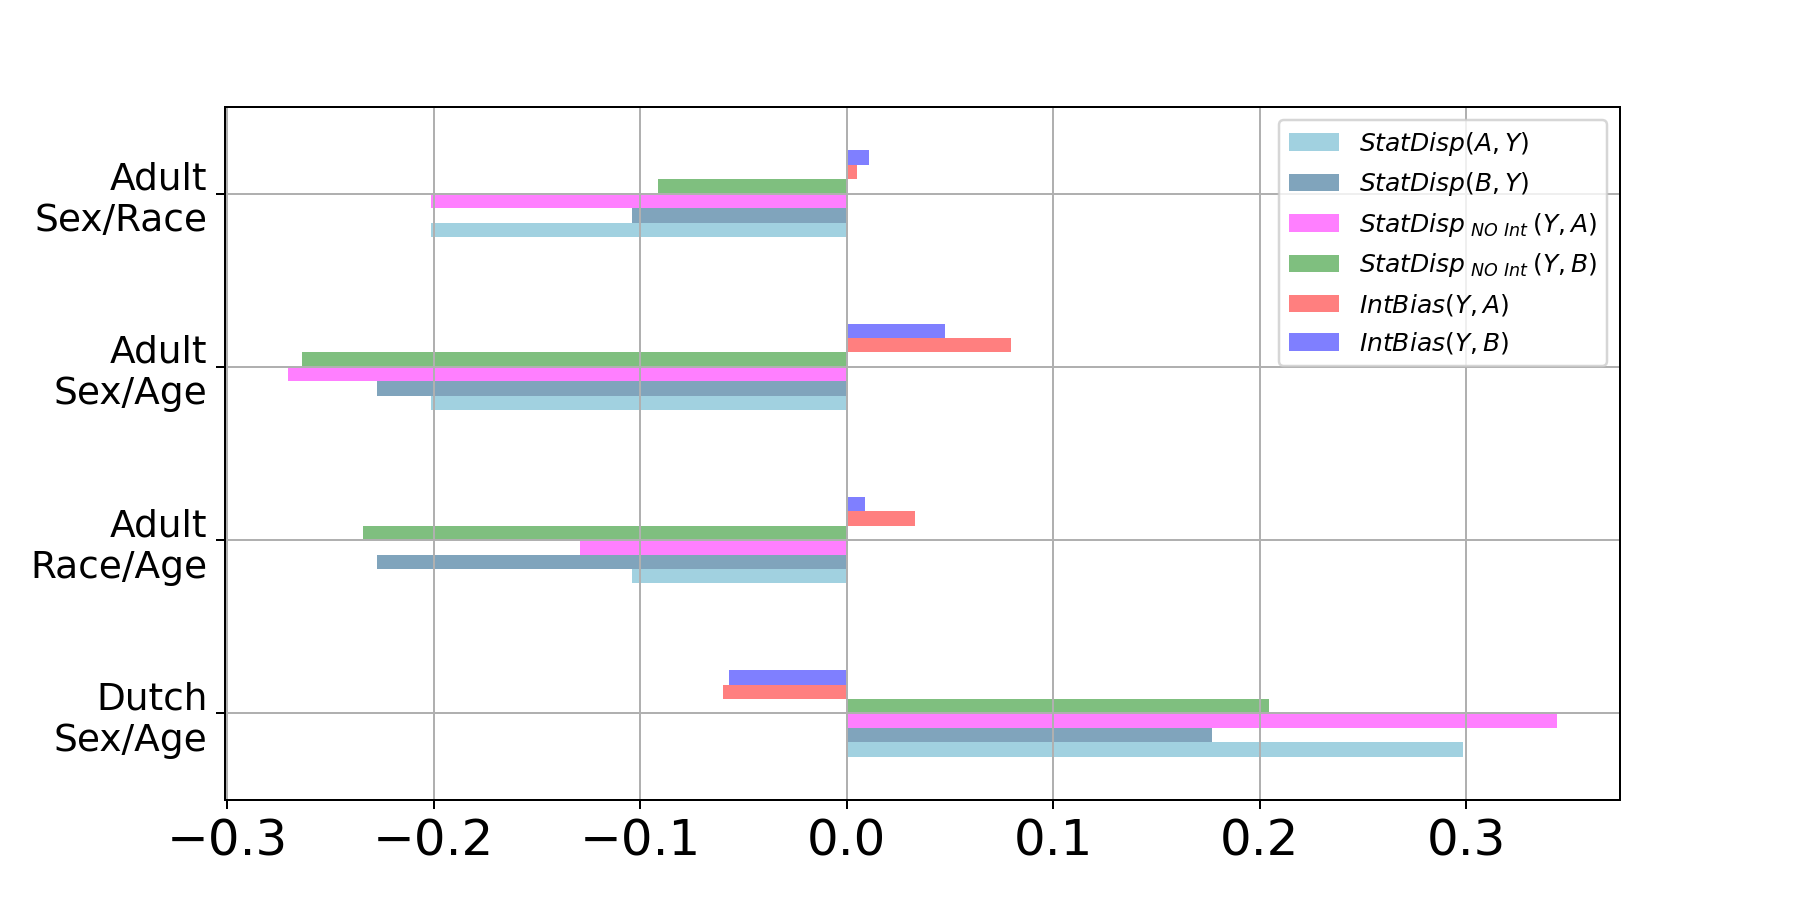

In [293]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

effects_A=(single_d1[0],single_a1[0],single_a2[0],single_a3[0])#statistical disparity no interaction
effects_B=(single_db1[0],single_b1[0],single_b2[0],single_b3[0])
IntBiasA =(single_d1[1],single_a1[1],single_a2[1],single_a3[1])
IntBiasB = (single_db1[1],single_b1[1],single_b2[1],single_b3[1])
total=(single_d1[2],single_a1[2],single_a2[2],single_a3[2])
SDA = (single_d1[3],single_a1[3],single_a2[3],single_a3[3])
SDB = (single_db1[3],single_b1[3],single_b2[3],single_b3[3])
#IntBiasA = (single_d1[3]-single_d1[2],single_a1[3]-single_a1[2],single_a2[3]-single_a2[2],single_a3[3]-single_a3[2])

names = ('Dutch\nSex/Age','Adult\nRace/Age', 'Adult\nSex/Age', 'Adult\nSex/Race')

df = pd.DataFrame({'$StatDisp(A,Y)$':SDA,'$StatDisp(B,Y)$':SDB, '$StatDisp_{~NO~Int~} (Y,A)$': effects_A,'$StatDisp_{~NO~Int~} (Y,B)$': effects_B,
                  '$IntBias(Y,A)$':IntBiasA, '$IntBias(Y,B)$':IntBiasB}, index=names)
df.plot.barh(color=["#44a5c2",  "#024b7a", 'magenta', 'green', 'r', 'b'], alpha=0.5, ax=ax)
plt.grid(False)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=15)
plt.grid(True)
plt.savefig('interactionA.png',bbox_inches='tight', dpi=300)

## Measurement Bias Synthetic

$MeasBias(Y,A) = ACE(Y,A)_{T} - ACE(Y,A)$

$ACE(Y,A) = \sum_{z}\left(P(y_1|a_1, z)-P(y_1|a_0, z)\right)P(z)$

$ ACE(Y,A)_T = \sum_{t}\left(P(y_1|a_1, t)-P(y_1|a_0, t)\right)P(t)$

In [246]:
np.random.rand(1)

array([0.94061803])

In [256]:
dfs=[]

seed=1

for i in range(5):
    pz=np.random.rand(1)
    pa1=np.random.rand(1)
    pa2=np.random.rand(1)
    pt1=np.random.rand(1)
    pt2=np.random.rand(1)
    print(i, 'pz:',pz, 'pa1',pa1, 'pa2' ,pa2,'pt1',pt1,'pt2',pt2 )
    


    z = np.random.binomial(1,pz,1000)
    a = [np.random.binomial(1,pa1,1)[0] if x==0 else np.random.binomial(1,pa2,1)[0] for x in z]
    t= [np.random.binomial(1,pt1,1)[0] if x==0 else np.random.binomial(1,pt2,1)[0] for x in z]
    y = [np.random.binomial(1,(x*0.5+y*0.5),1)[0] for x, y in zip(a,z)]
    df = pd.DataFrame({'Z':z, 'A':a, 'T':t, 'Y':y})
    
    dfs.append(df)

0 pz: [0.87588675] pa1 [0.39771641] pa2 [0.6173627] pt1 [0.66640694] pt2 [0.89363645]
1 pz: [0.94506311] pa1 [0.09733815] pa2 [0.52302683] pt1 [0.99579393] pt2 [0.69911278]
2 pz: [0.06418261] pa1 [0.70262236] pa2 [0.48285776] pt1 [0.83711411] pt2 [0.0902456]
3 pz: [0.55750089] pa1 [0.36904147] pa2 [0.09946441] pt1 [0.19567807] pt2 [0.73324647]
4 pz: [0.25308079] pa1 [0.96166705] pa2 [0.97120867] pt1 [0.66922194] pt2 [0.23883657]


In [257]:
df.head()

,Z,A,T,Y
0,1,1,1,1
1,1,1,0,1
2,0,1,0,0
3,0,0,0,0
4,0,1,1,1


In [258]:
def causaleffect(df,y, a, z): #using expression
    
    py1a0z0 = df[(df[y]==1)&(df[z]==0)&(df[a]==0)].shape[0]/df[(df[z]==0)&(df[a]==0)].shape[0]
    py1a0z1 = df[(df[y]==1)&(df[z]==1)&(df[a]==0)].shape[0]/df[(df[z]==1)&(df[a]==0)].shape[0]
    py1a1z0 = df[(df[y]==1)&(df[z]==0)&(df[a]==1)].shape[0]/df[(df[z]==0)&(df[a]==1)].shape[0]
    py1a1z1 = df[(df[y]==1)&(df[z]==1)&(df[a]==1)].shape[0]/df[(df[z]==1)&(df[a]==1)].shape[0]
    pz1 = df[(df[z]==1)].shape[0]/df.shape[0]
    pz0 = df[(df[z]==0)].shape[0]/df.shape[0]
    ydoa1 = (py1a1z1*pz1)+(py1a1z0*pz0)
    ydoa0 = (py1a0z1*pz1)+(py1a0z0*pz0)
    CE=ydoa1-ydoa0
    return CE

 

In [267]:
effects_T=[]
effects_Z=[]

mBias = []


for df in dfs:

    a = 'A'
    y = 'Y'
    z='Z'
    t='T'
    effZ = causaleffect(df,y, a, z)
    effT = causaleffect(df,y, a, t)
    effects_Z.append(effZ)
    effects_T.append(effT)
    mBias.append(effT-effZ)
  

In [270]:
effects_Z

[0.5100019102196752,
 0.484974115334207,
 0.5027253048780488,
 0.48791474540135854,
 0.44098933143669994]

<IPython.core.display.Javascript object>


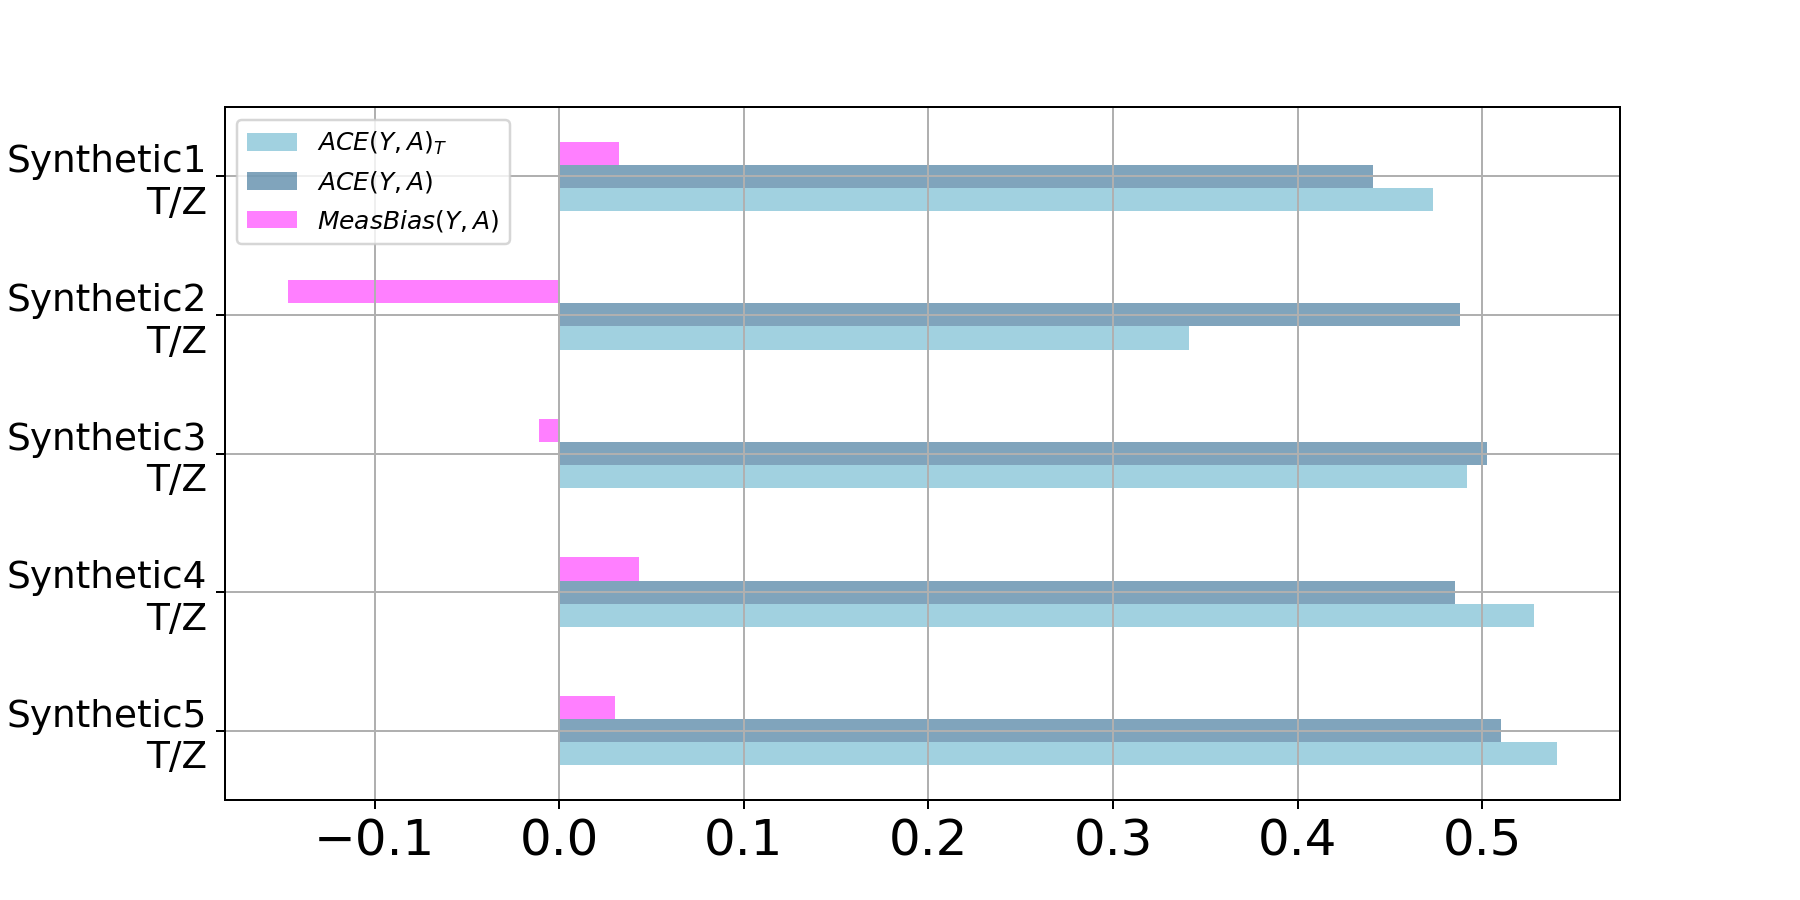

In [268]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')



names = ('Synthetic5\nT/Z','Synthetic4\nT/Z','Synthetic3\nT/Z','Synthetic2\nT/Z','Synthetic1\nT/Z')

df = pd.DataFrame({'$ACE(Y,A)_T$':effects_T,'$ACE(Y,A)$':effects_Z, '$MeasBias(Y,A)$':mBias}, index=names)
df.plot.barh(color=["#44a5c2",  "#024b7a", 'magenta', 'green', 'r'], alpha=0.5, ax=ax)
plt.grid(False)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=15)
plt.grid(True)
plt.savefig('MeasurementBias.png',bbox_inches='tight', dpi=300)

## Interaction Linear Case

\begin{equation}
InteractionBias(Y,A,B) = \beta_3
\end{equation}

\begin{equation}
InteractionBias(Y,A) = \beta_3P(B=1)
\end{equation}

\begin{equation}
InteractionBias(Y,B) = \beta_3P(A=1)
\end{equation}

In [ ]:
a = np.random.binomial(1,0.5,1000)
b = np.random.binomial(1,0.5,1000)
c = np.random.normal(5,2,1000)
y = 3+0.3*a+0.1*b+0.6*a*b+0.2*c
df = pd.DataFrame({'A':a, 'B':b, 'C':c, 'Y':y })

In [726]:
import numpy as np
from sklearn.linear_model import LinearRegression
def estimateInteractionBias_AB(n,alpha,beta,gamma):
    a = np.random.binomial(1,alpha,n)
    b = np.random.binomial(1,beta,n)
    c = np.random.normal(5,2,n)
    y = 3+0.3*a+0.3*b+gamma*a*b+0.4*c
    df = pd.DataFrame({'A':a, 'B':b, 'C':c, 'Y':y })
    
    X=df.drop('Y', axis=1)
    y=df.Y
    reg = LinearRegression().fit(X, y)
    
    biasAB = (reg.coef_[0]+reg.coef_[1]) - (0.5+0.5+gamma)
    biasAB0 = (reg.coef_[0]) - 0.3
    biasAB1 = (reg.coef_[0]) - (0.3+gamma)
    biasABavg = (reg.coef_[0]) - (0.3+gamma*beta)
    
    
    
    return biasAB,  biasAB0, biasAB1, biasABavg
    
    

In [669]:
n=10000
alpha = 0.9
beta = 0.9
gamma= 0.9
estimateInteractionBias_AB(n,alpha,beta,gamma)

0.7138010203435301

In [677]:
np.arange(0.001,1,0.01)

array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991])

In [720]:
np.arange(0.001,1.01,0.1)

array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
       6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00])

In [899]:
def generateConf4DPlotData(n):

    data = np.zeros((1,4))
    maxVal = -math.inf
    minVal = math.inf
    for alpha in np.arange(0.001,1,0.01):
        for beta in np.arange(0.001,1,0.01):
            for gamma in np.arange(0.001,1,0.01):
                biasVal = estimateInteractionBias_AB(n,alpha,beta,gamma)
                data = np.vstack((data,np.array([alpha,beta,gamma,biasVal])))
                if biasVal > maxVal:
                    maxVal = biasVal
                    alphaMax = alpha
                    betaMax = beta
                    gammaMax = gamma
                if biasVal < minVal:
                    alphaMin = alpha
                    minVal = biasVal
                    betaMin = beta
                    gammaMin = gamma
    print('Max bias = ', maxVal, '(alpha=', alphaMax, 'beta=', betaMax, 'gamma=', gammaMax,')')
    print('Min bias = ', minVal, '(alpha=', alphaMin, 'beta=', betaMin, 'gamma=', gammaMin,')')
    return data

def generateConf4DPlotData2(n):
    
    ALPHA = []
    BETA = []
    GAMMA = []
    BiasAB = []
    BiasAB0 = []
    BiasAB1 = []
    BiasABavg = []
    

    data = np.zeros((1,4))
    maxVal = -math.inf
    minVal = math.inf
    for alpha in np.arange(0.001,1,0.1):

        for beta in np.arange(0.001,1,0.1):

            for gamma in np.arange(-1,1,0.1):
                biasAB,  biasAB0, biasAB1, biasABavg = estimateInteractionBias_AB(n,alpha,beta,gamma)
                ALPHA.append(alpha)
                BETA.append(beta)
                GAMMA.append(gamma)
                BiasAB.append(biasAB)
                BiasAB0.append(biasAB0)
                BiasAB1.append(biasAB1)
                BiasABavg.append(biasABavg)
  
    return  ALPHA, BETA, GAMMA, BiasAB, BiasAB0, BiasAB1, BiasABavg

In [679]:
res = generateConf4DPlotData(1000)

Max bias =  0.9910000000000105 (alpha= 0.8309999999999998 beta= 0.9909999999999999 gamma= 0.9909999999999999 )
Min bias =  -1.9609999999999999 (alpha= 0.001 beta= 0.001 gamma= 0.9609999999999999 )


In [700]:
X=[]
Y=[]
Z=[]
maxBias=[]
for r in res:
     x,y,z,bias = r
     X.append(x)
     Y.append(y)
     Z.append(z)
     maxBias.append(bias)
X=np.array(X)        
Y=np.array(Y)
Z=np.array(Z)
maxBias=np.array(maxBias)


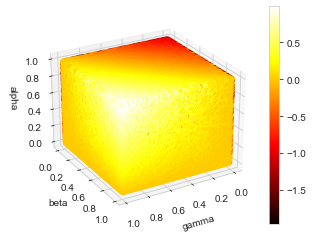

In [723]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


img = ax.scatter(X, Y, Z, c=maxBias, cmap=plt.hot())
#img = ax.scatter(x, y, z, c=c)

ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('alpha')

ax.view_init(25, 60)


fig.colorbar(img)
plt.show() 

In [900]:
# ALPHA, BETA, GAMMA, BiasAB, BiasAB0, BiasAB1, BiasABavg = generateConf4DPlotData2(10000)

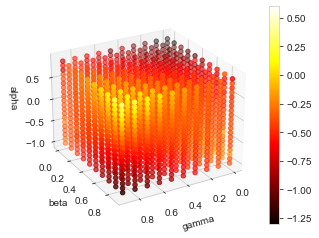

In [911]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array(ALPHA)
Y = np.array(BETA)
Z = np.array(GAMMA)
B = np.array(BiasAB)


img = ax.scatter(X, Y, Z, c=B, cmap=plt.hot())
#img = ax.scatter(x, y, z, c=c)

ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('alpha')

ax.view_init(25, 60)


fig.colorbar(img)
plt.show() 
fig.savefig('3D_interactionbiasA1B1.png')

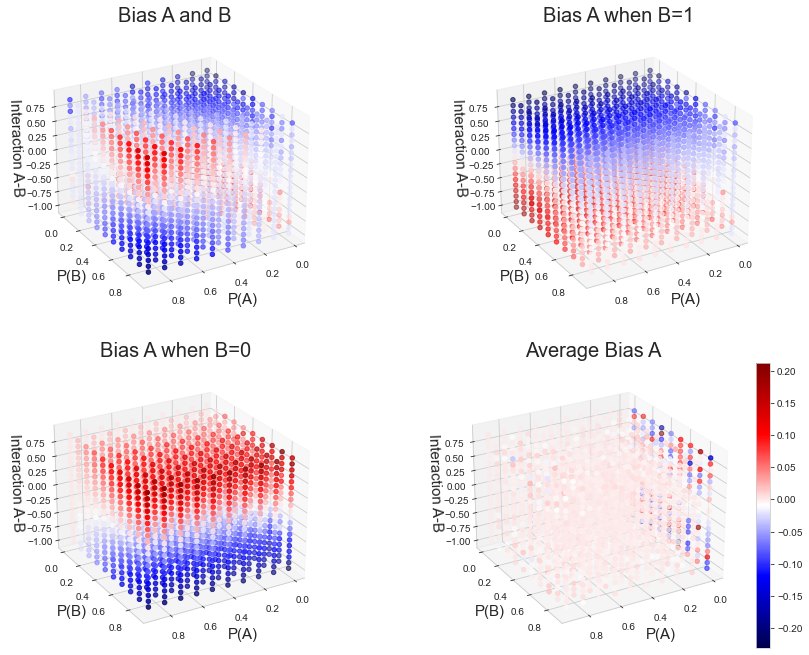

In [903]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(221, projection='3d')

cmap = 'seismic'#'PRGn'

plt.tight_layout(pad=5)

X = np.array(ALPHA)
Y = np.array(BETA)
Z = np.array(GAMMA)
B = np.array(BiasAB)


img = ax.scatter(X, Y, Z, c=B, cmap=cmap)


ax.set_xlabel('P(A)', size=15)
ax.set_ylabel('P(B)', size=15)
ax.set_zlabel('Interaction A-B', size=15)
ax.set_title('Bias A and B', size =20)
ax.view_init(25, 60)

ax1 = fig.add_subplot(222, projection='3d')

X = np.array(ALPHA)
Y = np.array(BETA)
Z = np.array(GAMMA)
B = np.array(BiasAB1)


img = ax1.scatter(X, Y, Z, c=B, cmap=cmap)

ax1.set_xlabel('P(A)', size=15)
ax1.set_ylabel('P(B)', size=15)
ax1.set_zlabel('Interaction A-B', size=15)

ax1.view_init(25, 60)

ax1.set_title('Bias A when B=1', size =20)

ax1 = fig.add_subplot(223, projection='3d')

X = np.array(ALPHA)
Y = np.array(BETA)
Z = np.array(GAMMA)
B = np.array(BiasAB0)


img = ax1.scatter(X, Y, Z, c=B, cmap=cmap)

ax1.set_xlabel('P(A)', size=15)
ax1.set_ylabel('P(B)', size=15)
ax1.set_zlabel('Interaction A-B', size=15)

ax1.set_title('Bias A when B=0', size =20)


ax1.view_init(25, 60)

ax1 = fig.add_subplot(224, projection='3d')

X = np.array(ALPHA)
Y = np.array(BETA)
Z = np.array(GAMMA)
B = np.array( BiasABavg)

img = ax1.scatter(X, Y, Z, c=B, cmap=cmap)

ax1.set_xlabel('P(A)', size=15)
ax1.set_ylabel('P(B)', size=15)
ax1.set_zlabel('Interaction A-B', size=15)
ax1.view_init(25, 60)

ax1.set_title('Average Bias A', size =20)


fig.colorbar(img)
plt.show() 
fig.savefig('3D_interactionbiases.png', bbox_inches = 'tight')


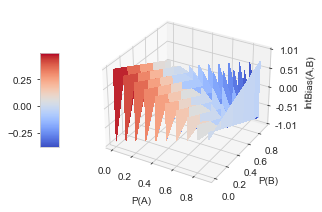

In [936]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plt.tight_layout(pad=5)
# Make data.
X = ALPHA
Y = BETA
X, Y = np.meshgrid(X, Y)
R = GAMMA*(X+ Y-1)
Z = R

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(5))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('P(A)', size=10)
ax.set_ylabel('P(B)', size=10)
ax.set_zlabel('IntBias(A,B)', size=10)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5,location='left')

plt.show()
fig.savefig('AB)_interaction_surface_plot.png', bbox_inches = 'tight')

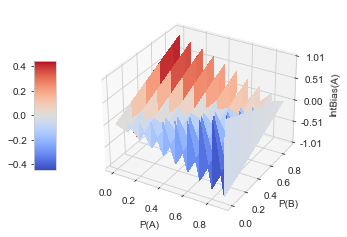

In [932]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = ALPHA
Y = BETA
X, Y = np.meshgrid(X, Y)
R = GAMMA*(X-Y)
Z = R

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(5))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('P(A)', size=10)
ax.set_ylabel('P(B)', size=10)
ax.set_zlabel('IntBias(A)', size=10)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5,location='left')

plt.show()
fig.savefig('A_avginteractionbias_surface_plot.png', bbox_inches = 'tight')

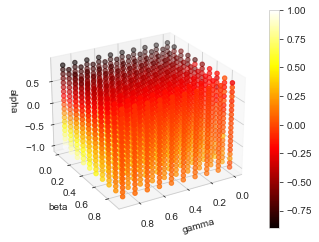

In [909]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array(ALPHA)
Y = np.array(BETA)
Z = np.array(GAMMA)
B = np.array(BiasAB1)


img = ax.scatter(X, Y, Z, c=B, cmap=plt.hot())
#img = ax.scatter(x, y, z, c=c)

ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('alpha')

ax.view_init(25, 60)


fig.colorbar(img)
plt.show() 
fig.savefig('3D_interactionbiasAwhenB=1.png')

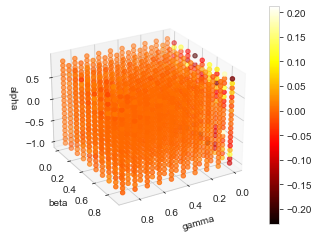

In [910]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array(ALPHA)
Y = np.array(BETA)
Z = np.array(GAMMA)
B = np.array(BiasABavg)


img = ax.scatter(X, Y, Z, c=B, cmap=plt.hot())
#img = ax.scatter(x, y, z, c=c)

ax.set_xlabel('gamma')
ax.set_ylabel('beta')
ax.set_zlabel('alpha')

ax.view_init(25, 60)


fig.colorbar(img)
plt.show() 
fig.savefig('3D_averageinteractionbiasA.png')

In [912]:
results=pd.DataFrame({ 'P(A)':ALPHA, 'P(B)':BETA, 'Interaction A-B':GAMMA, 'Bias AB':BiasAB, 'Bias A when B=0':BiasAB0, 'Bias A when B=1':BiasAB1, 'Average bias A':BiasABavg})


<Figure size 432x288 with 0 Axes>

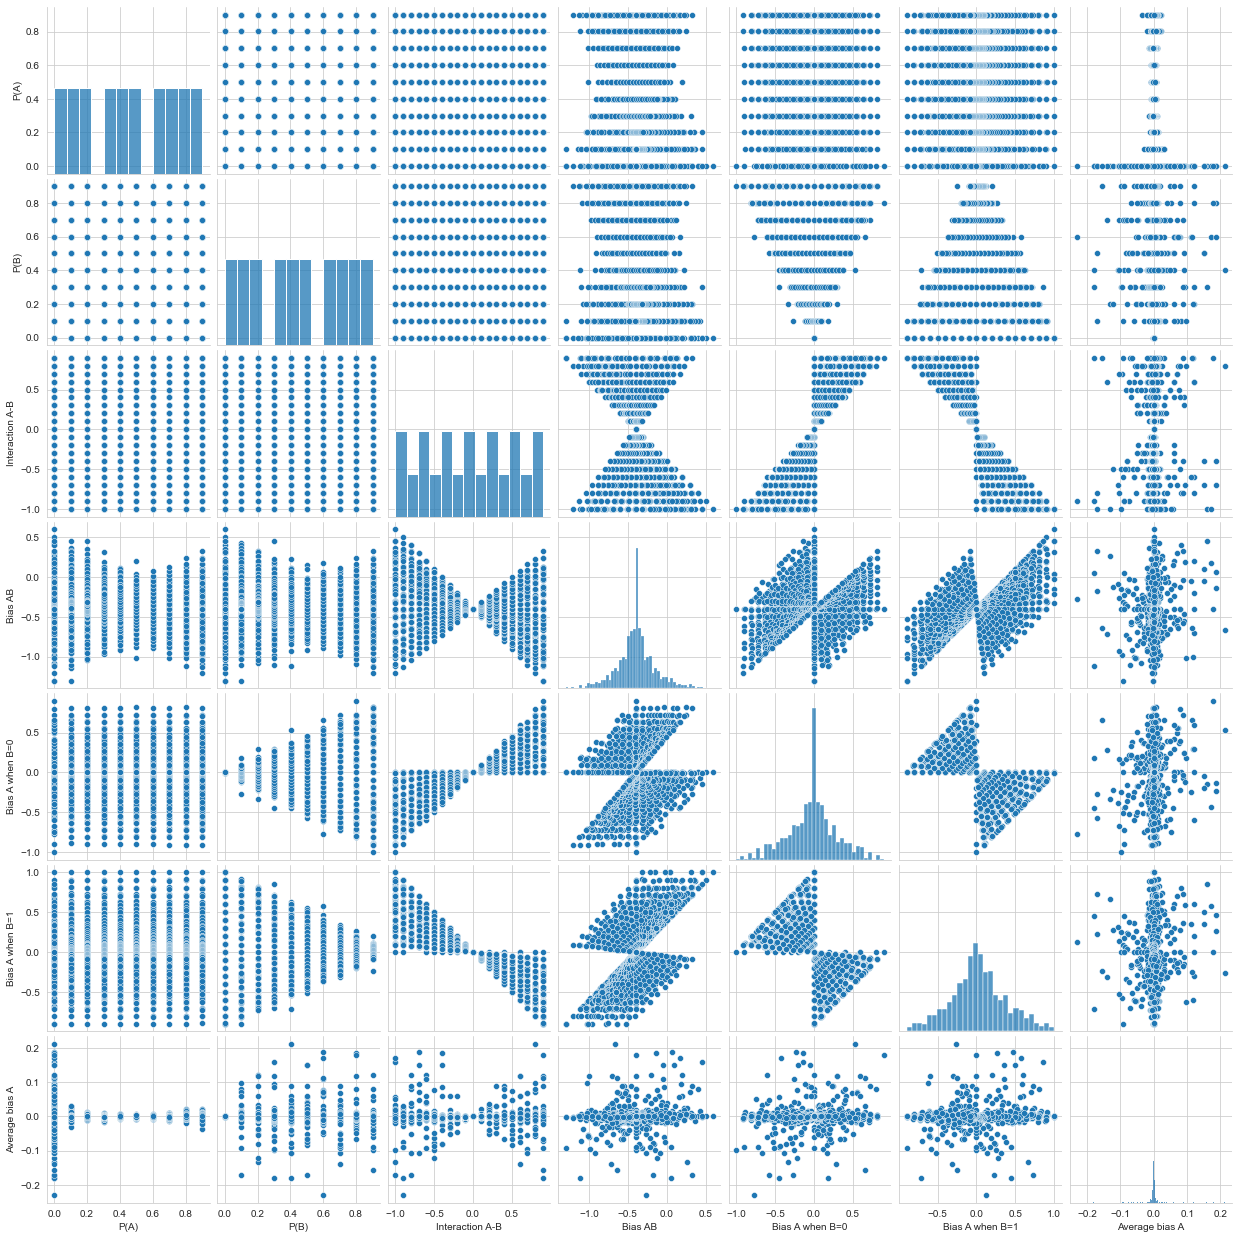

In [913]:
import seaborn as sns
fig = plt.figure()

sns.pairplot(results)

plt.savefig('pairplot_interactionbiases.png')

In [766]:
maxAB = results['Bias AB'].max()
results[results['Bias AB']==maxAB]

,P(A),P(B),Interaction A-B,Bias AB,Bias A when B=0,Bias A when B=1,Average bias A
1099,0.901,0.901,1.001,0.417401,0.908243,-0.092757,0.006342


In [767]:
maxAB0 = results['Bias A when B=0'].max()
results[results['Bias A when B=0']==maxAB0]

,P(A),P(B),Interaction A-B,Bias AB,Bias A when B=0,Bias A when B=1,Average bias A
109,0.001,0.901,1.001,-0.4,1.001,-3.330669e-15,0.099099


In [770]:
maxAB1 = results['Bias A when B=1'].min()
results[results['Bias A when B=1']==maxAB1]

,P(A),P(B),Interaction A-B,Bias AB,Bias A when B=0,Bias A when B=1,Average bias A
450,0.401,0.001,1.001,-1.401,2.775558e-16,-1.001,-0.001001


In [773]:
maxAavg= results['Average bias A'].max()
results[results['Average bias A']==maxAavg]

,P(A),P(B),Interaction A-B,Bias AB,Bias A when B=0,Bias A when B=1,Average bias A
75,0.001,0.601,0.901,-0.469074,0.831578,-0.069422,0.290077


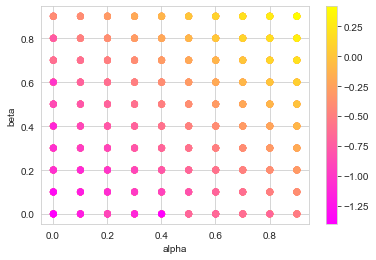

In [797]:
fig = plt.figure()
ax = fig.add_subplot(111)

X = np.array(ALPHA)
Y = np.array(BETA)
Z = np.array(GAMMA)
B = np.array(BiasAB)


img = ax.scatter(X, Y, c=B, cmap=plt.spring())
#img = ax.scatter(x, y, z, c=c)

ax.set_xlabel('alpha')
ax.set_ylabel('beta')





fig.colorbar(img)
plt.show() 
plt.savefi

## Interaction Bias Linear Case NEW

In [142]:
a = np.random.binomial(1,0.5,1000)
b = np.random.binomial(1,0.5,1000)
c = np.random.normal(5,2,1000)
y = 3+0.3*a+0.1*b+0.6*a*b+0.2*c
df = pd.DataFrame({'A':a, 'B':b, 'C':c, 'Y':y })

In [120]:
dfaa = pd.read_csv('Adult/adult_cleaned_not_bin.csv')

In [121]:
dfaa['race'] = [0 if x==4 else 1 for x in dfaa.race]#binarize

In [89]:
dfaa['Sex']=dfaa['Sex'].replace({0:1,1:0})

In [115]:
dfaa.head()

,age,workclass,education,marital_status,occupation,relationship,race,hours_per_week,native_country,income,Sex
0,90,0,9,4,8,1,0,40,39,0,1
1,82,1,9,4,3,1,0,18,39,0,1
2,66,0,10,4,8,4,1,40,39,0,1
3,54,1,4,0,6,4,0,40,39,0,1
4,41,1,10,2,10,3,0,40,39,0,1


In [152]:
reg.coef_

array([0.60067293, 0.4040664 , 0.19986057])

In [153]:
#without interaction
from sklearn.linear_model import LinearRegression
import numpy as np
df = df
# df.drop('interaction', axis=1, inplace=True)
X=df.drop('Y', axis=1)
y=df.Y
reg = LinearRegression().fit(X, y)
print('Confidence:',reg.score(X, y))
EcoefA=reg.coef_[0]
EcoefB=reg.coef_[1]

print('coefA, coefB, coefAB',round(EcoefA,3), round(EcoefB,3))
reg.coef_

Confidence: 0.9263779792727102
coefA, coefB, coefAB 0.601 0.404


array([0.60067293, 0.4040664 , 0.19986057])

In [156]:
#with interaction
import numpy as np
df['interaction'] = df.A*df.B
df = df
from sklearn.linear_model import LinearRegression
X=df.drop('Y', axis=1)

y=df.Y
reg = LinearRegression().fit(X, y)
print('Confidence:',reg.score(X, y))
EcoefA=reg.coef_[0]
EcoefB=reg.coef_[1]
# 
EcoefAB=reg.coef_[3]
print('coefA, coefB, coefAB',round(EcoefA,3), round(EcoefB,3),round(EcoefAB,3) )
reg.coef_

Confidence: 1.0
coefA, coefB, coefAB 0.3 0.1 0.6


array([0.3, 0.1, 0.2, 0.6])